# **MIE 1517 Group Project Team 10:**
# Enhancing Mobile Robot Perception in Urban Environments via Dual-Stream Encoder

### Team Member:
Yang-Chen Lin, Nazib Chowdhury, Lucheng Zhou, Amirreza Azad

# Overview

In this project, we will focus on Autoencoder architecture, more on the decoder. We will train our model on Cityscape image dataset, then we will test our model performance on our dashcam videos we took from Toronto downtown. In the process of completing this project, we will:
  1.  Understanding Mobile-Seed architecture
  2.  Training Hybrid Dynamic Adaptive Feature Fusion (DAFF) decoder
  3.  Comparing Performance of Mobile-Seed with modified LBSNet architecture
  3.  Clean and Process dashcam video for test data

# Introduction
Accurate perception is crucial for mobile robots in urban environments, enabling tasks like navigation and obstacle avoidance. Semantic segmentation plays a key role, but deploying it in real-time remains challenging due to computational constraints.

While recent lightweight models, such as Mobile-Seed, integrate semantic segmentation and boundary detection for improved efficiency, there is still room for architectural enhancement. Specifically, the Active Fusion Decoder (AFD), which fuses semantic and boundary features, can be further optimized to enhance segmentation accuracy without increasing computational costs.

Our project focuses on refining Mobile-Seed’s AFD fusion decoder and both segmentation adn boundary stream lines to improve its fusion strategy, ensuring more effective integration of semantic and boundary information. This optimization aims to enhance segmentation performance while maintaining the model’s lightweight efficiency.

# Project Environment Setup



Modified Mobile-Seed Github link: https://github.com/iolj-uoft/Mobile-Seed-MIE1517

Environment Settings:\
In this project, we train our model on Ubuntu 22.04. If you're using Windows, you can either use WSL2, or modify some of the commands below to run on powershell.
The conda environment config file can be downloaded at this link: https://drive.google.com/file/d/1GHaD-N2y_8_LrkpjTlrl6PdJNh44q4MV/view?usp=sharing\
. Next, run the following commands:

```
git clone https://github.com/iolj-uoft/Mobile-Seed-MIE1517.git
conda env create -f /path/to/environment.yml
conda activate mobileseed
mim install mmengine
mim install mmcv-full
cd Mobile-Seed
pip install -v -e .
```
And the environment setup is done.


# Data Collection

The current model is trained on the Cityscapes dataset (https://www.cityscapes-dataset.com/), which is a well-labelled cityview dataset that's specifically provided to develop deep-learning models in urban environments. The training used this dataset. In our project, we used 2975 finely annotated images for training, and 500 images for evaluation. The data splitting are shown as follows:

    . 2975 images for training
    . 500  images for validation and evaluation
    . 1250 images for test (it's for internal benchmarking so it's not public accessible)

For the testing stage, we will use a real time footage from a personal vehicle dashcam recording urban scenes in Toronto to demo our model's performance.
The dashcam footage captures diverse urban elements, including vehicles, pedestrians, and road infrastructure.

## Dataset Preprocessing

The original authors provide processed Cityscapes on [onedrive](https://whueducn-my.sharepoint.com/:f:/g/personal/martin_liao_whu_edu_cn/EjklDmgVOitPrhuAwy6h6EkBPkyTvnlCkTN0BdjPIIc6xA?e=1i6D4Z) and [baidudisk](https://pan.baidu.com/s/1DD1LkEaTFUtabbJtTh_8iw?pwd=tpe4 )(code: tpe4). If you want to process the data from scratch, please refer to following steps:
- Download the files gtFine_trainvaltest.zip, leftImg8bit_trainvaltest.zip and leftImg8bit_demoVideo.zip from the [Cityscapes website](https://www.cityscapes-dataset.com/) to data_orig/, and unzip them:
```
unzip data_orig/gtFine_trainvaltest.zip -d data_orig && rm data_orig/gtFine_trainvaltest.zip
unzip data_orig/leftImg8bit_trainvaltest.zip -d data_orig && rm data_orig/leftImg8bit_trainvaltest.zip
unzip data_orig/leftImg8bit_demoVideo.zip -d data_orig && rm data_orig/leftImg8bit_demoVideo.zip
```
- create training semantic label:
``
python data_preprocess/cityscapes_preprocess/code/createTrainIdLabelImgs.py <data_path>
``
- Generate .png training semantic boundary labels by running the following command:
```
# In Matlab Command Window
run code/demoPreproc_gen_png_label.m
```
This will create **instance-insensitive** semantic boundary labels for network training in ``data_proc_nis/``.

# Mobile-Seed Approach
Mobile-Seed is a lightweight deep learning framework designed for real-time semantic segmentation and boundary detection. Unlike conventional models that focus only on segmentation, Mobile-Seed incorporates boundary awareness to improve object delineation while maintaining efficiency.

The architecture consists of:


1.   Two-Stream Encoder – A semantic stream for category-aware features and a boundary stream for fine-grained edge detection.
2.   Active Fusion Decoder (AFD) – Dynamically merges features using adaptive attention-based fusion.
3.   Dual-Task Regularization – Resolves conflicts between segmentation and boundary detection for stable learning.

The Mobile-Seed framework is shown in Figure 1.

**Figure 1: Mobile-Seed Architecture**
(Adapted from Liao et al., 2024 [1])
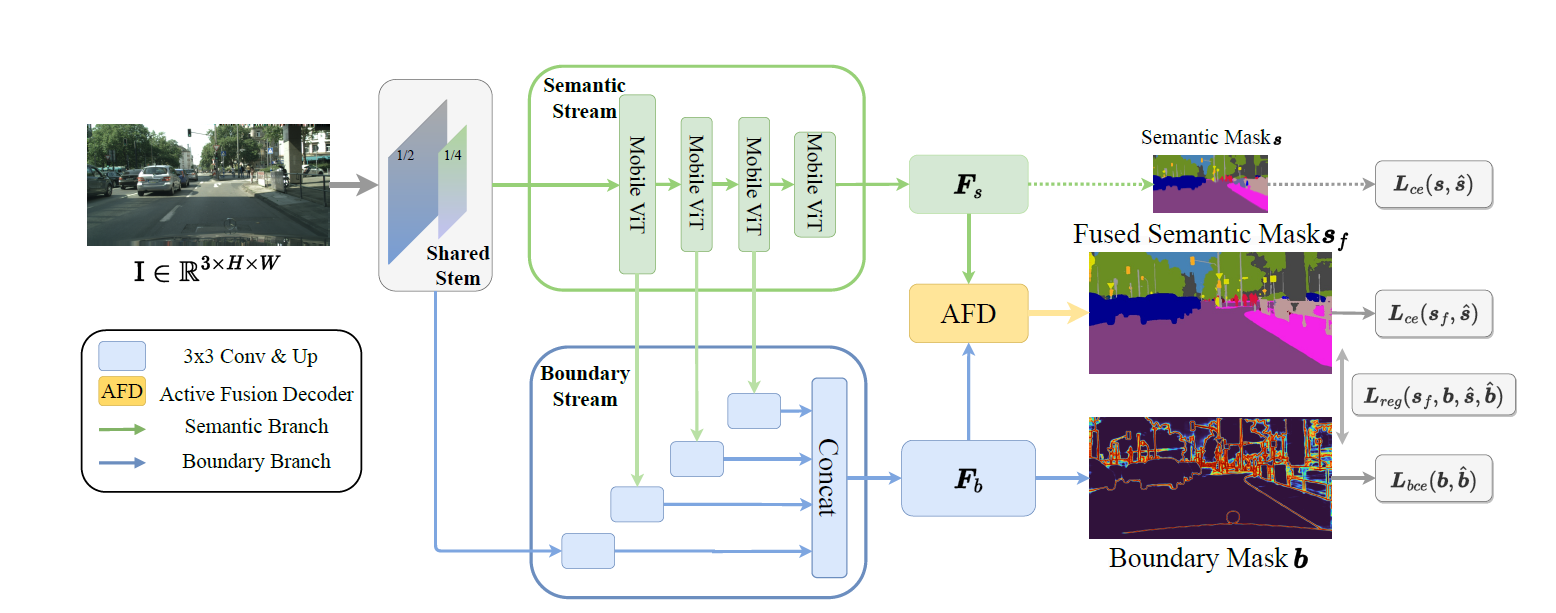

Active Fusion Decoder (AFD)
The AFD module is key to Mobile-Seed’s efficiency. Unlike fixed-weight fusion methods, AFD learns adaptive fusion weights to balance semantic and boundary features dynamically.


*   Global Attention Mechanism – Computes channel-wise attention for both streams.
*   Feature Fusion – Dynamically adjusts fusion weights based on input conditions.
*   Residual Enhancement – Ensures precise feature integration without excessive computation.

AFD’s workflow is illustrated in Figure 2.

**Figure 2: Active Fusion Decoder (AFD)**
(Adapted from Liao et al., 2024 [1])
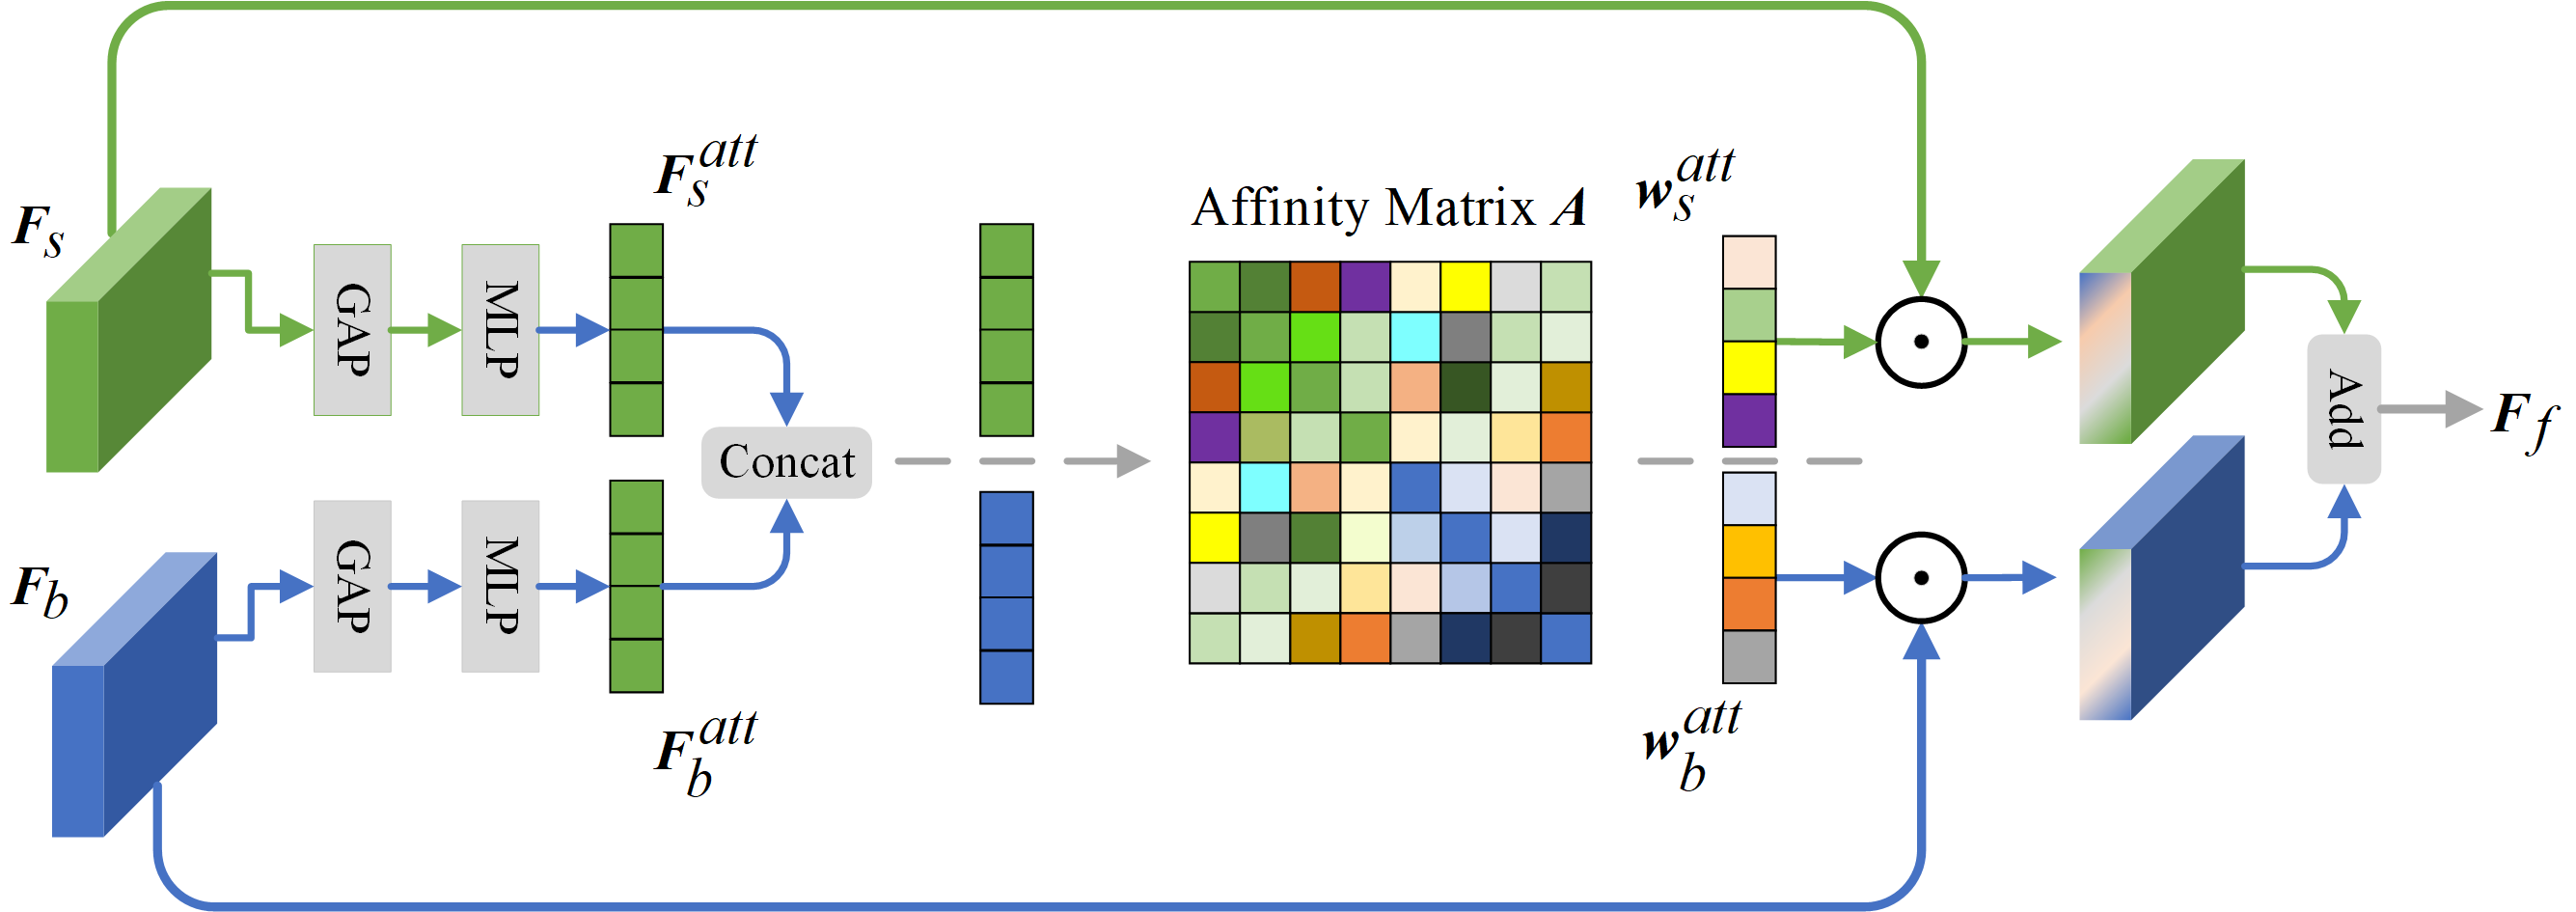

## The python class for the AFD:

In [ ]:
class AFD(nn.Module):
    "Active fusion decoder"
    def __init__(self, s_channels,c_channels, conv_cfg, norm_cfg, act_cfg, h=8):
        super(AFD, self).__init__()
        self.s_channels = s_channels
        self.c_channels = c_channels
        self.h = h
        self.scale = h ** - 0.5
        self.spatial_att = ChannelAtt(s_channels, s_channels, conv_cfg, norm_cfg, act_cfg)
        self.context_att = ChannelAtt(c_channels, c_channels, conv_cfg, norm_cfg, act_cfg)
        self.qkv = nn.Linear(s_channels + c_channels,(s_channels + c_channels) * 3,bias = False)
        self.proj = nn.Linear(s_channels + c_channels, s_channels + c_channels)
        self.proj_drop = nn.Dropout(0.1)

    def forward(self, sp_feat, co_feat):
        # **_att: B x C x 1 x 1
        s_feat, s_att = self.spatial_att(sp_feat)
        c_feat, c_att = self.context_att(co_feat)
        b = s_att.shape[0] # h = 1, w = 1
        sc_att = torch.cat([s_att,c_att],1).view(b,-1) # [B,2C]
        qkv = self.qkv(sc_att).reshape(b,1,3,self.h, (self.c_channels + self.s_channels) // self.h).permute(2,0,3,1,4) # [B,2C] -> [B,6C] -> [B,1,3,h,2C // h] -> [3,B,h,1,2C // h]
        q,k,v = qkv[0],qkv[1],qkv[2] # [B,h,1,2C // h]
        k_softmax = k.softmax(dim = 1) # channel-wise softmax operation
        k_softmax_T_dot_v = einsum("b h n k, b h n v -> b h k v", k_softmax, v) # [B,h,2C // h ,2C // h]
        fuse_weight = self.scale * einsum("b h n k, b h k v -> b h n v", q,
                            k_softmax_T_dot_v) # [B,h,1,2C // h]
        fuse_weight = fuse_weight.transpose(1,2).reshape(b,-1) # [B,C]
        fuse_weight = self.proj(fuse_weight)
        fuse_weight = self.proj_drop(fuse_weight)
        fuse_weight = fuse_weight.reshape(b,-1,1,1) # [B,C,1,1]
        fuse_s,fuse_c = fuse_weight[:,:self.s_channels],fuse_weight[:,-self.c_channels:]
        out = (1 + fuse_s) * s_feat + (1 + fuse_c) * c_feat
        return s_feat, c_feat, out

**References**

[1] Y. Liao et al., "Mobile-Seed: Joint Semantic Segmentation and Boundary Detection for Mobile Robots," IEEE Robotics and Automation Letters, 2024.

# LBSNet Intuition

We can see that the model was not making a perfect classification on the object boundaries from the previous Mobile Seed segmentation result. There are several misclassification existing in the output. To improve the Mobile-Seed architecture for better boundary classification, we propose incorporating insights from the Lightweight Boundary-Semantic Network (LBSNet). LBSNet specializes in boundary-aware techniques, excelling at delineating objects like glass or mirrors that have ambiguous appearances. While Mobile-Seed is designed for efficient, real-time segmentation on mobile robots, its Active Fusion Decoder (AFD) struggles with such challenging cases due to its broad fusion strategy. Our enhancement introduces a boundary-guided refinement module to the AFD, leveraging boundary predictions to refine segmentation outputs, particularly at critical edges. This lightweight addition aims to boost precision while maintaining Mobile-Seed’s real-time performance.

The modified decoder enhances segmentation by producing sharper boundaries and improving the handling of visually unclear objects, drawing on LBSNet’s strengths. However, it also brings challenges, such as increased complexity in tuning and reliance on accurate boundary predictions, which could degrade performance if boundaries are imprecise. Despite these trade-offs, the integration strikes a balance between precision and efficiency, making it well-suited for mobile robotics in complex environments. This upgrade enhances Mobile-Seed’s capability to tackle diverse scenes without compromising its core advantage of speed.

**Figure 3. LBSNet Architecture**
(Adapted from Tong et al., 2025 [2])
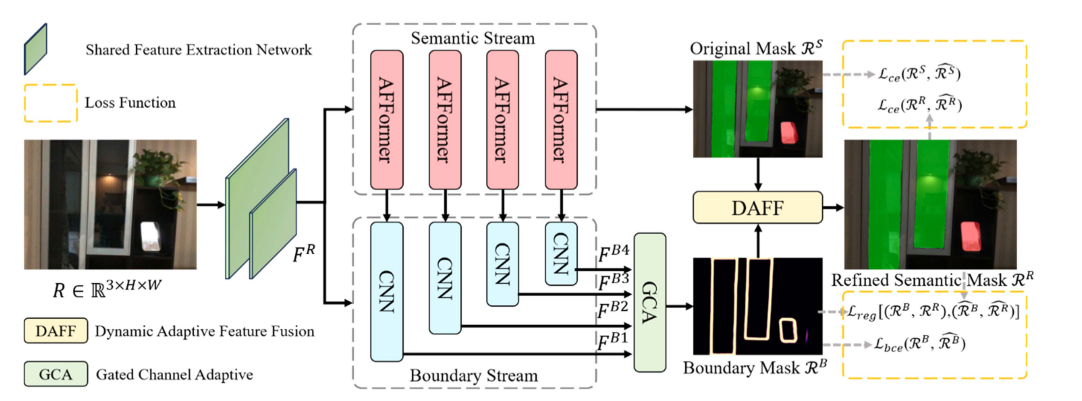

At the heart of LBSNet lies the Dynamic Adaptive Feature Fusion (DAFF) decoder, which dynamically integrates semantic and boundary features to produce high-quality segmentation and boundary outputs. DAFF employs sophisticated components like the Attention Former (AF) module, which refines semantic features through attention mechanisms, and the Gated Channel Adaptive (GCA) module, which enhances boundary details by adaptively weighting channel contributions. This combination allows DAFF to balance global context and local edge information effectively while remaining computationally lightweight. In contrast, Mobile-Seed’s Active Fusion Decoder (AFD) merges semantic and boundary streams but may struggle with objects that have indistinct appearances, leading to suboptimal boundary precision. Replacing AFD with DAFF involves feeding Mobile-Seed’s semantic and boundary features into DAFF’s fusion pipeline, leveraging its attention-based and gated mechanisms to improve feature integration, and aligning the outputs with Mobile-Seed’s dual-task objectives.
By incorporating DAFF into Mobile-Seed, we anticipate significant improvements in image segmentation and boundary detection, especially in complex urban scenes. DAFF’s adaptive fusion enhances segmentation accuracy by better distinguishing overlapping or visually similar objects, such as pedestrians near vehicles, while its boundary-focused design sharpens edges in challenging cases like wet surfaces or glass. The multi-scale feature integration of DAFF also outperforms AFD by capturing both broad context and fine details, reducing segmentation errors across diverse environments. Although this upgrade slightly increases computational demands, DAFF’s efficient architecture ensures Mobile-Seed retains real-time performance, making it a powerful enhancement for mobile robotics applications requiring precise and reliable scene understanding.

**Figure 4: DAFF Architecture**
(Adapted from Tong et al., 2025 [2])
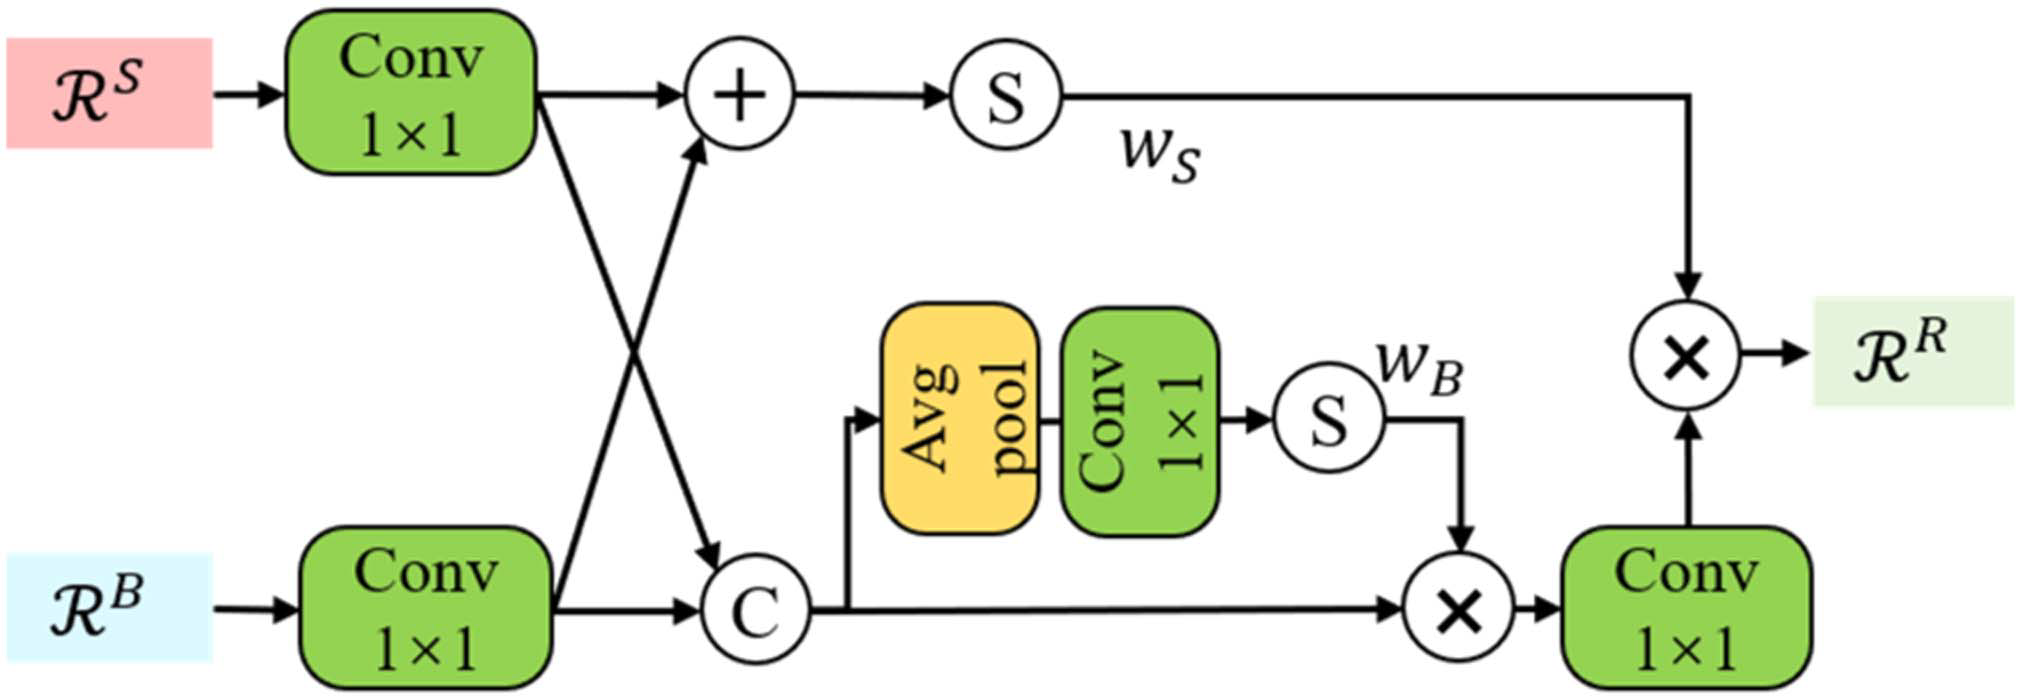

**Reference:**
[2] L. Tong, K. Qian, and X. Jing, "LBSNet: Lightweight Joint Boundary Detection and Semantic Segmentation for Transparent and Reflective Objects," IEEE Robotics and Automation Letters, vol. 10, no. 2, pp. 955-962, Feb. 2025, doi: 10.1109/LRA.2024.3518302.

# AFD and DAFF Decoder Demo

The following code provides a demonstration comparing the performance of the AFD decoder and the DAFF decoder. It is intended solely for illustrative purposes and does not represent the full training or deployment pipeline.

Epoch [10/100], Loss: 3.0010, Semantic Loss: 1.6462, Boundary Loss: 0.6774
Epoch [20/100], Loss: 2.8651, Semantic Loss: 1.5363, Boundary Loss: 0.6644
Epoch [30/100], Loss: 2.8083, Semantic Loss: 1.4866, Boundary Loss: 0.6609
Epoch [40/100], Loss: 2.7655, Semantic Loss: 1.4508, Boundary Loss: 0.6573
Epoch [50/100], Loss: 2.7290, Semantic Loss: 1.4216, Boundary Loss: 0.6537
Epoch [60/100], Loss: 2.6959, Semantic Loss: 1.3961, Boundary Loss: 0.6499
Epoch [70/100], Loss: 2.6641, Semantic Loss: 1.3721, Boundary Loss: 0.6460
Epoch [80/100], Loss: 2.6329, Semantic Loss: 1.3487, Boundary Loss: 0.6421
Epoch [90/100], Loss: 2.6026, Semantic Loss: 1.3263, Boundary Loss: 0.6381
Epoch [100/100], Loss: 2.5732, Semantic Loss: 1.3050, Boundary Loss: 0.6341


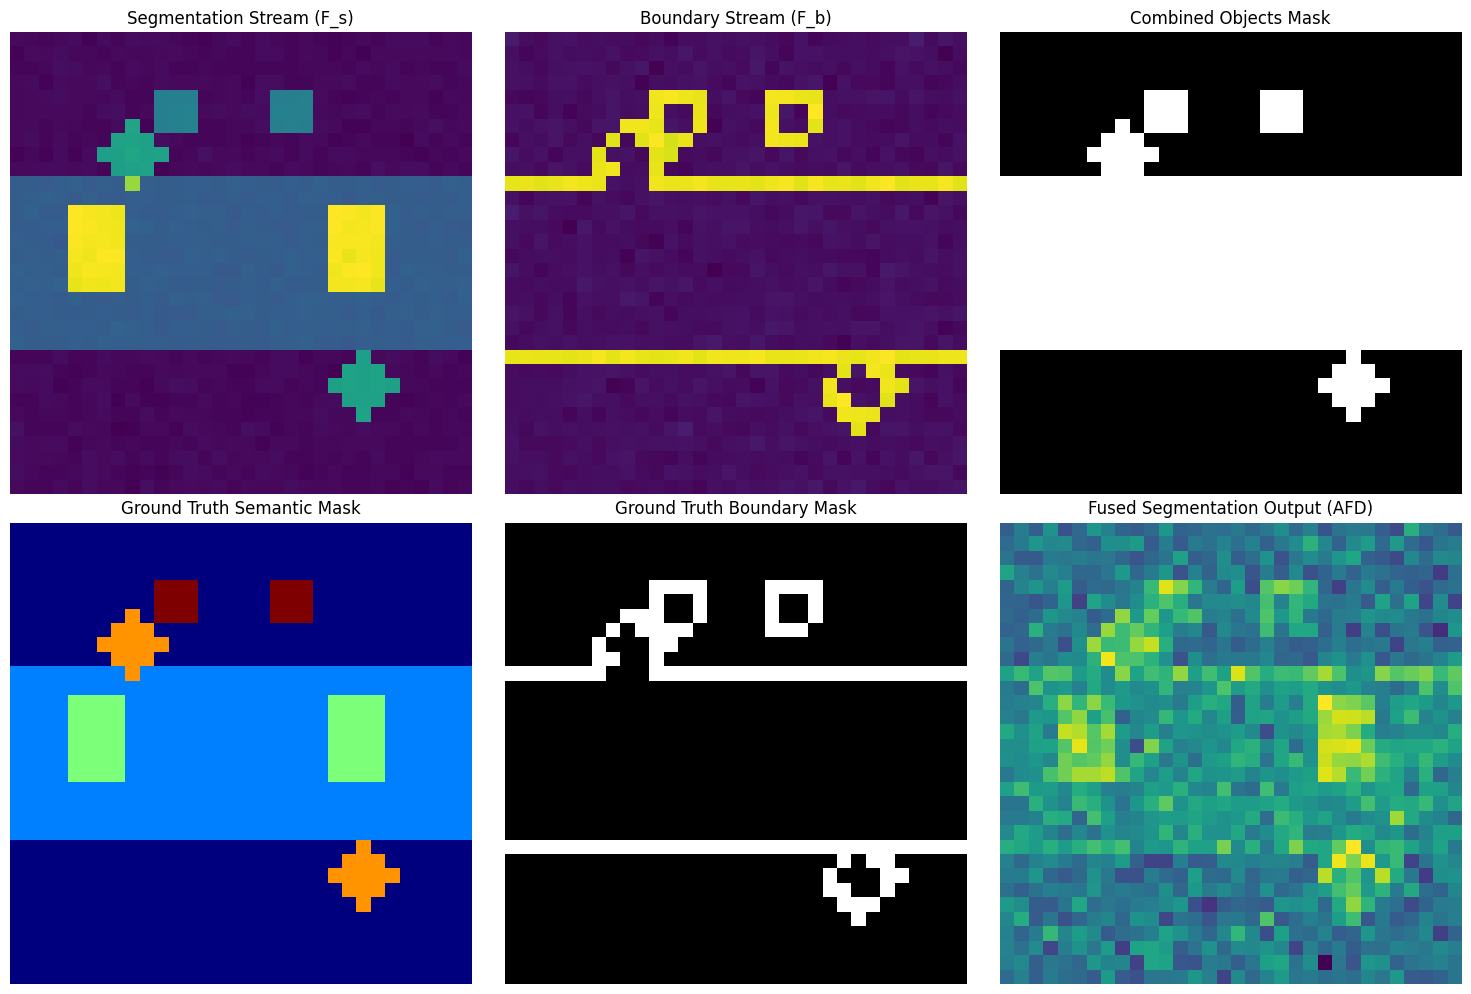

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)

# Define the ChannelAtt module (used by AFD)
class ChannelAtt(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ChannelAtt, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        feat = self.conv(x)  # [B, out_channels, H, W]
        att = feat.mean(dim=(2, 3))  # [B, out_channels]
        return feat, att

# Define the AFD (Active Fusion Decoder) module without prediction heads
class AFD(nn.Module):
    def __init__(self, s_channels, c_channels, fuse_channels, num_classes, h=8):
        super(AFD, self).__init__()
        self.s_channels = s_channels  # e.g., 384
        self.c_channels = c_channels  # e.g., 256
        self.fuse_channels = fuse_channels  # e.g., 256
        self.num_classes = num_classes  # e.g., 5 for synthetic data
        self.h = h
        self.scale = h ** -0.5

        # Attention mechanisms for spatial and context features
        self.spatial_att = ChannelAtt(s_channels, s_channels)
        self.context_att = ChannelAtt(c_channels, c_channels)

        # QKV linear layer for attention
        self.qkv = nn.Linear(s_channels + c_channels, (s_channels + c_channels) * 3, bias=False)

        # Projection for fusion weights
        self.proj = nn.Linear(s_channels + c_channels, 2 * fuse_channels)
        self.proj_drop = nn.Dropout(0.1)

        # Feature projection layers
        self.s_proj = nn.Conv2d(s_channels, fuse_channels, kernel_size=1)
        self.c_proj = nn.Conv2d(c_channels, fuse_channels, kernel_size=1)

        # Temporary projection layers for loss computation
        self.s_loss_proj = nn.Conv2d(s_channels, num_classes, kernel_size=1)  # Project F_s to class map
        self.c_loss_proj = nn.Conv2d(c_channels, 1, kernel_size=1)  # Project F_b to binary edge map

    def forward(self, sp_feat, co_feat):
        # sp_feat (F_s): [B, s_channels, H, W]
        # co_feat (F_b): [B, c_channels, H, W]

        # Apply attention to segmentation (spatial) and boundary (context) features
        s_feat, s_att = self.spatial_att(sp_feat)  # [B, 384, H, W], [B, 384]
        c_feat, c_att = self.context_att(co_feat)  # [B, 256, H, W], [B, 256]

        b = s_att.shape[0]
        sc_att = torch.cat([s_att, c_att], dim=1)  # [B, 384 + 256] = [B, 640]

        # Compute QKV for attention mechanism
        qkv = self.qkv(sc_att).reshape(b, 1, 3, self.h, (self.s_channels + self.c_channels) // self.h)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # [3, B, h, 1, (s_channels + c_channels) / h]
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: [B, h, 1, 80] if h=8

        # Attention computation
        k_softmax = k.softmax(dim=1)
        k_softmax_T_dot_v = torch.einsum("b h n k, b h n v -> b h k v", k_softmax, v)
        fuse_weight = self.scale * torch.einsum("b h n k, b h k v -> b h n v", q, k_softmax_T_dot_v)

        # Project fusion weights
        fuse_weight = fuse_weight.transpose(1, 2).reshape(b, self.s_channels + self.c_channels)  # [B, 640]
        fuse_weight = self.proj(fuse_weight)  # [B, 2 * 256] = [B, 512]
        fuse_weight = self.proj_drop(fuse_weight)
        fuse_weight = fuse_weight.reshape(b, 2 * self.fuse_channels, 1, 1)  # [B, 512, 1, 1]

        # Split fusion weights for segmentation and boundary streams
        fuse_s = fuse_weight[:, :self.fuse_channels]  # [B, 256, 1, 1]
        fuse_c = fuse_weight[:, self.fuse_channels:]  # [B, 256, 1, 1]

        # Project features to fuse_channels
        s_feat_proj = self.s_proj(s_feat)  # [B, 256, H, W]
        c_feat_proj = self.c_proj(c_feat)  # [B, 256, H, W]

        # Fuse the features
        out = (1 + fuse_s) * s_feat_proj + (1 + fuse_c) * c_feat_proj  # [B, 256, H, W]

        # Project F_s and F_b for loss computation
        s_for_loss = self.s_loss_proj(sp_feat)  # [B, num_classes, H, W]
        c_for_loss = self.c_loss_proj(co_feat)  # [B, 1, H, W]

        return s_feat, c_feat, out, s_for_loss, c_for_loss

# Function to generate complex synthetic segmentation and boundary streams (with ground truth)
def generate_samples(batch_size=2, H=32, W=32):
    # Initialize the base masks
    mask_road = torch.zeros(batch_size, 1, H, W)
    mask_vehicle1 = torch.zeros(batch_size, 1, H, W)
    mask_vehicle2 = torch.zeros(batch_size, 1, H, W)
    mask_pedestrian1 = torch.zeros(batch_size, 1, H, W)
    mask_pedestrian2 = torch.zeros(batch_size, 1, H, W)
    mask_traffic_sign1 = torch.zeros(batch_size, 1, H, W)
    mask_traffic_sign2 = torch.zeros(batch_size, 1, H, W)

    # Define the road (horizontal strip from y=10 to y=22)
    mask_road[:, :, 10:22, :] = 1

    # Define vehicle 1 (car on the left side of the road, 6x4 rectangle)
    mask_vehicle1[:, :, 12:18, 4:8] = 1

    # Define vehicle 2 (car on the right side of the road, 6x4 rectangle)
    mask_vehicle2[:, :, 12:18, 22:26] = 1

    # Define pedestrian 1 (circular region on the left side, radius 2)
    y1, x1 = 8, 8  # Center of pedestrian 1
    for y in range(H):
        for x in range(W):
            if (x - x1) ** 2 + (y - y1) ** 2 <= 2 ** 2:  # Radius 2
                mask_pedestrian1[:, :, y, x] = 1

    # Define pedestrian 2 (circular region on the right side, radius 2)
    y2, x2 = 24, 24  # Center of pedestrian 2
    for y in range(H):
        for x in range(W):
            if (x - x2) ** 2 + (y - y2) ** 2 <= 2 ** 2:  # Radius 2
                mask_pedestrian2[:, :, y, x] = 1

    # Define traffic sign 1 (small square above the road, 3x3)
    mask_traffic_sign1[:, :, 4:7, 10:13] = 1

    # Define traffic sign 2 (small square above the road, 3x3)
    mask_traffic_sign2[:, :, 4:7, 18:21] = 1

    # Create a synthetic semantic ground truth (class labels)
    # Class IDs: 0=background, 1=road, 2=vehicle, 3=pedestrian, 4=traffic sign
    semantic_gt = torch.zeros(batch_size, H, W, dtype=torch.long)
    semantic_gt[mask_road.squeeze(1) == 1] = 1  # Road
    semantic_gt[mask_vehicle1.squeeze(1) == 1] = 2  # Vehicle 1
    semantic_gt[mask_vehicle2.squeeze(1) == 1] = 2  # Vehicle 2
    semantic_gt[mask_pedestrian1.squeeze(1) == 1] = 3  # Pedestrian 1
    semantic_gt[mask_pedestrian2.squeeze(1) == 1] = 3  # Pedestrian 2
    semantic_gt[mask_traffic_sign1.squeeze(1) == 1] = 4  # Traffic sign 1
    semantic_gt[mask_traffic_sign2.squeeze(1) == 1] = 4  # Traffic sign 2

    # Combine masks for F_s with different intensities for each object type
    F_s_base = torch.randn(batch_size, 384, H, W)
    F_s = F_s_base.clone()
    F_s += 2 * mask_road.expand_as(F_s_base)  # Road: intensity +2
    F_s += 5 * mask_vehicle1.expand_as(F_s_base)  # Vehicle 1: intensity +5
    F_s += 5 * mask_vehicle2.expand_as(F_s_base)  # Vehicle 2: intensity +5
    F_s += 4 * mask_pedestrian1.expand_as(F_s_base)  # Pedestrian 1: intensity +4
    F_s += 4 * mask_pedestrian2.expand_as(F_s_base)  # Pedestrian 2: intensity +4
    F_s += 3 * mask_traffic_sign1.expand_as(F_s_base)  # Traffic sign 1: intensity +3
    F_s += 3 * mask_traffic_sign2.expand_as(F_s_base)  # Traffic sign 2: intensity +3

    # Compute a combined mask for boundary detection
    combined_mask = torch.zeros_like(mask_road)
    combined_mask += mask_road
    combined_mask += mask_vehicle1
    combined_mask += mask_vehicle2
    combined_mask += mask_pedestrian1
    combined_mask += mask_pedestrian2
    combined_mask += mask_traffic_sign1
    combined_mask += mask_traffic_sign2
    combined_mask = (combined_mask > 0).float()  # Binary mask of all objects

    # Compute boundaries for F_b and ground truth
    boundary_mask = torch.zeros_like(combined_mask)
    boundary_mask[:, :, 1:, :] = combined_mask[:, :, 1:, :] - combined_mask[:, :, :-1, :]  # Vertical edges
    boundary_mask[:, :, :, 1:] += combined_mask[:, :, :, 1:] - combined_mask[:, :, :, :-1]  # Horizontal edges
    boundary_mask = (boundary_mask != 0).float()  # Binary mask (1 for edges)

    # Generate F_b with higher activations along the boundaries
    F_b_base = torch.randn(batch_size, 256, H, W)
    F_b = F_b_base + 5 * boundary_mask.expand_as(F_b_base)

    return F_s, F_b, semantic_gt, boundary_mask, combined_mask

# Main execution for AFD
if __name__ == "__main__":
    # Set device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Parameters
    B, H, W = 2, 32, 32
    num_classes = 5  # Background, road, vehicle, pedestrian, traffic sign

    # Generate synthetic inputs and ground truth
    F_s, F_b, semantic_gt, boundary_mask, combined_mask = generate_samples(batch_size=B, H=H, W=W)
    F_s, F_b = F_s.to(device), F_b.to(device)
    semantic_gt = semantic_gt.to(device)
    boundary_mask = boundary_mask.to(device)

    # Initialize AFD decoder
    decoder = AFD(s_channels=384, c_channels=256, fuse_channels=256, num_classes=num_classes).to(device)

    # Define loss functions
    semantic_loss_fn = nn.CrossEntropyLoss()
    boundary_loss_fn = nn.BCEWithLogitsLoss()

    # Optimizer (only for the decoder)
    optimizer = optim.Adam(decoder.parameters(), lr=0.0005)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        decoder.train()

        optimizer.zero_grad()

        # Forward pass through AFD decoder
        s_feat, c_feat, out, s_for_loss, c_for_loss = decoder(F_s, F_b)

        # Compute losses
        semantic_loss = semantic_loss_fn(s_for_loss, semantic_gt)  # Compare projected F_s with semantic_gt
        boundary_loss = boundary_loss_fn(c_for_loss, boundary_mask)  # Compare projected F_b with boundary_mask
        total_loss = semantic_loss + 2 * boundary_loss  # Increase weight of boundary loss

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}, "
                  f"Semantic Loss: {semantic_loss.item():.4f}, Boundary Loss: {boundary_loss.item():.4f}")

    # Evaluate and visualize after training
    decoder.eval()
    with torch.no_grad():
        s_feat, c_feat, out, _, _ = decoder(F_s, F_b)

        # Move to CPU and convert to NumPy for visualization
        F_s_np = F_s.mean(dim=1).cpu().numpy()  # Average over channels
        F_b_np = F_b.mean(dim=1).cpu().numpy()  # Average over channels
        combined_mask_np = combined_mask.cpu().numpy().squeeze(1)  # [B, H, W]
        boundary_mask_np = boundary_mask.cpu().numpy().squeeze(1)  # [B, H, W]
        semantic_gt_np = semantic_gt.cpu().numpy()  # [B, H, W]
        fused_output_np = out.mean(dim=1).cpu().numpy()  # Average over channels, [B, H, W]

    # Visualize the inputs, ground truth, and fused output for the first sample
    plt.figure(figsize=(15, 10))

    # Segmentation stream (F_s)
    plt.subplot(2, 3, 1)
    plt.imshow(F_s_np[0], cmap='viridis')
    plt.title("Segmentation Stream (F_s)")
    plt.axis('off')

    # Boundary stream (F_b)
    plt.subplot(2, 3, 2)
    plt.imshow(F_b_np[0], cmap='viridis')
    plt.title("Boundary Stream (F_b)")
    plt.axis('off')

    # Combined mask
    plt.subplot(2, 3, 3)
    plt.imshow(combined_mask_np[0], cmap='gray')
    plt.title("Combined Objects Mask")
    plt.axis('off')

    # Ground truth semantic mask
    plt.subplot(2, 3, 4)
    plt.imshow(semantic_gt_np[0], cmap='jet')
    plt.title("Ground Truth Semantic Mask")
    plt.axis('off')

    # Ground truth boundary mask
    plt.subplot(2, 3, 5)
    plt.imshow(boundary_mask_np[0], cmap='gray')
    plt.title("Ground Truth Boundary Mask")
    plt.axis('off')

    # Fused segmentation output
    plt.subplot(2, 3, 6)
    plt.imshow(fused_output_np[0], cmap='viridis')
    plt.title("Fused Segmentation Output (AFD)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

Epoch [10/100], Loss: 2.9351, Semantic Loss: 1.5868, Boundary Loss: 0.6741
Epoch [20/100], Loss: 2.8859, Semantic Loss: 1.5544, Boundary Loss: 0.6657
Epoch [30/100], Loss: 2.8000, Semantic Loss: 1.4758, Boundary Loss: 0.6621
Epoch [40/100], Loss: 2.7653, Semantic Loss: 1.4486, Boundary Loss: 0.6584
Epoch [50/100], Loss: 2.7312, Semantic Loss: 1.4223, Boundary Loss: 0.6545
Epoch [60/100], Loss: 2.7021, Semantic Loss: 1.4012, Boundary Loss: 0.6504
Epoch [70/100], Loss: 2.6719, Semantic Loss: 1.3792, Boundary Loss: 0.6463
Epoch [80/100], Loss: 2.6426, Semantic Loss: 1.3583, Boundary Loss: 0.6421
Epoch [90/100], Loss: 2.6139, Semantic Loss: 1.3381, Boundary Loss: 0.6379
Epoch [100/100], Loss: 2.5856, Semantic Loss: 1.3184, Boundary Loss: 0.6336


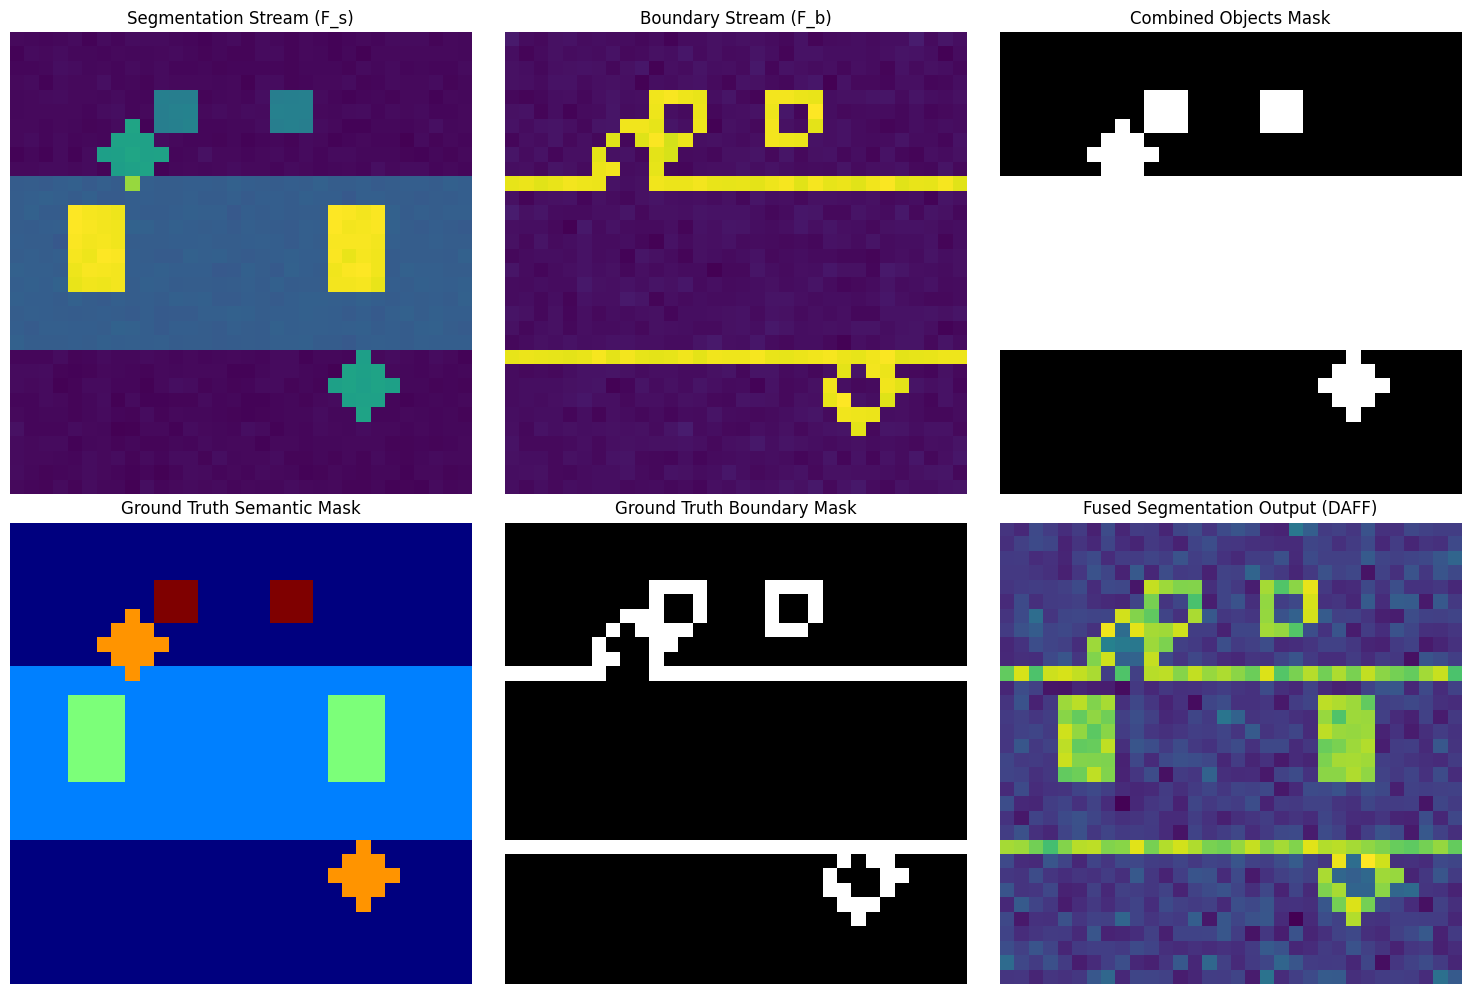

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(0)

# Define the DAFF (Dual Attention Fusion Framework) module without prediction heads
class DAFF(nn.Module):
    def __init__(self, s_channels, c_channels, fuse_channels, num_classes):
        super(DAFF, self).__init__()
        self.s_channels = s_channels  # e.g., 384
        self.c_channels = c_channels  # e.g., 256
        self.fuse_channels = fuse_channels  # e.g., 256
        self.num_classes = num_classes  # e.g., 5 for synthetic data

        # 1x1 Convolution for semantic stream (R^S -> S)
        self.conv_s = nn.Sequential(
            nn.Conv2d(s_channels, fuse_channels, kernel_size=1),
            nn.BatchNorm2d(fuse_channels),
            nn.ReLU()
        )

        # 1x1 Convolution for boundary stream (R^B -> C) with enhancement
        self.conv_c = nn.Sequential(
            nn.Conv2d(c_channels, fuse_channels, kernel_size=1),
            nn.BatchNorm2d(fuse_channels),
            nn.ReLU()
        )

        # Boundary attention: Compute w_S with a more sophisticated mechanism
        self.w_s_conv = nn.Sequential(
            nn.Conv2d(fuse_channels, fuse_channels // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(fuse_channels // 4, fuse_channels, kernel_size=1),
            nn.Sigmoid()  # Sigmoid to produce attention weights
        )

        # Semantic attention: Compute w_B with a more sophisticated mechanism
        self.w_b_conv = nn.Sequential(
            nn.Conv2d(2*fuse_channels, fuse_channels // 4, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(fuse_channels // 4, 2*fuse_channels, kernel_size=1),
            nn.Sigmoid()
        )

        # Cross-attention for better fusion
        self.cross_attention = nn.MultiheadAttention(embed_dim=fuse_channels, num_heads=8)

        # Final 1x1 convolution to produce R^R with residual connection
        self.conv_final = nn.Sequential(
            nn.Conv2d(2*fuse_channels, fuse_channels, kernel_size=1),
            nn.BatchNorm2d(fuse_channels),
            nn.ReLU()
        )

        # Temporary projection layers for loss computation
        self.s_loss_proj = nn.Conv2d(s_channels, num_classes, kernel_size=1)  # Project F_s to class map
        self.c_loss_proj = nn.Conv2d(c_channels, 1, kernel_size=1)  # Project F_b to binary edge map

    def forward(self, sp_feat, co_feat):
        # sp_feat (F_s): [B, s_channels, H, W]
        # co_feat (F_b): [B, c_channels, H, W]

        # Step 1: Process semantic stream (R^S -> S)
        S = self.conv_s(sp_feat)  # [B, fuse_channels, H, W]

        # Step 2: Process boundary stream (R^B -> C)
        C = self.conv_c(co_feat)  # [B, fuse_channels, H, W]

        # Step 3: Add C to S (initial fusion)
        S_plus_C = S + C  # [B, fuse_channels, H, W]
        S_concat_C = torch.cat([S, C], dim=1)  # [B, 2*fuse_channels, H, W]

        # Step 4: Compute w_S (boundary attention)
        # C_avg = torch.mean(C, dim=(2, 3), keepdim=True)  # Global average pooling: [B, fuse_channels, 1, 1]
        sc_concat_avg = torch.mean(S_concat_C, dim=(2, 3), keepdim=True)  # Global average pooling: [B, 2*fuse_channels, 1, 1]
        w_S = self.w_s_conv(S_plus_C)  # [B, fuse_channels, H, W]

        # Step 5: Compute w_B (semantic attention)
        w_B = self.w_b_conv(sc_concat_avg)  # [B, fuse_channels, 1, 1]

        # Step 6: Apply weights to S
        # S_weighted_s = S_plus_C * w_S  # [B, fuse_channels, H, W]
        S_weighted_b = S_concat_C * w_B  # [B, 2*fuse_channels, H, W]
        b_out = self.conv_final(S_weighted_b) # [B,fuse_channels, H, W]

        # Step 7: Cross-attention for better fusion
        # Reshape for multi-head attention: [B, fuse_channels, H, W] -> [B, H*W, fuse_channels]
        # B, C, H, W = S_weighted_s.shape
        # S_weighted_s_flat = S_weighted_s.view(B, C, H * W).permute(0, 2, 1)  # [B, H*W, fuse_channels]
        # S_weighted_b_flat = S_weighted_b.view(B, C, H * W).permute(0, 2, 1)  # [B, H*W, fuse_channels]
        # fused_flat, _ = self.cross_attention(S_weighted_s_flat, S_weighted_b_flat, S_weighted_b_flat)  # [B, H*W, fuse_channels]
        # fused = fused_flat.permute(0, 2, 1).view(B, C, H, W)  # [B, fuse_channels, H, W]

        # Step 8: Final convolution with residual connection
        out = b_out * w_S  # Residual connection with S: [B, fuse_channels, H, W]

        # Project F_s and F_b for loss computation
        s_for_loss = self.s_loss_proj(sp_feat)  # [B, num_classes, H, W]
        c_for_loss = self.c_loss_proj(co_feat)  # [B, 1, H, W]

        return S, C, out, s_for_loss, c_for_loss

# Function to generate complex synthetic segmentation and boundary streams (with ground truth)
def generate_samples(batch_size=2, H=32, W=32):
    # Initialize the base masks
    mask_road = torch.zeros(batch_size, 1, H, W)
    mask_vehicle1 = torch.zeros(batch_size, 1, H, W)
    mask_vehicle2 = torch.zeros(batch_size, 1, H, W)
    mask_pedestrian1 = torch.zeros(batch_size, 1, H, W)
    mask_pedestrian2 = torch.zeros(batch_size, 1, H, W)
    mask_traffic_sign1 = torch.zeros(batch_size, 1, H, W)
    mask_traffic_sign2 = torch.zeros(batch_size, 1, H, W)

    # Define the road (horizontal strip from y=10 to y=22)
    mask_road[:, :, 10:22, :] = 1

    # Define vehicle 1 (car on the left side of the road, 6x4 rectangle)
    mask_vehicle1[:, :, 12:18, 4:8] = 1

    # Define vehicle 2 (car on the right side of the road, 6x4 rectangle)
    mask_vehicle2[:, :, 12:18, 22:26] = 1

    # Define pedestrian 1 (circular region on the left side, radius 2)
    y1, x1 = 8, 8  # Center of pedestrian 1
    for y in range(H):
        for x in range(W):
            if (x - x1) ** 2 + (y - y1) ** 2 <= 2 ** 2:  # Radius 2
                mask_pedestrian1[:, :, y, x] = 1

    # Define pedestrian 2 (circular region on the right side, radius 2)
    y2, x2 = 24, 24  # Center of pedestrian 2
    for y in range(H):
        for x in range(W):
            if (x - x2) ** 2 + (y - y2) ** 2 <= 2 ** 2:  # Radius 2
                mask_pedestrian2[:, :, y, x] = 1

    # Define traffic sign 1 (small square above the road, 3x3)
    mask_traffic_sign1[:, :, 4:7, 10:13] = 1

    # Define traffic sign 2 (small square above the road, 3x3)
    mask_traffic_sign2[:, :, 4:7, 18:21] = 1

    # Create a synthetic semantic ground truth (class labels)
    # Class IDs: 0=background, 1=road, 2=vehicle, 3=pedestrian, 4=traffic sign
    semantic_gt = torch.zeros(batch_size, H, W, dtype=torch.long)
    semantic_gt[mask_road.squeeze(1) == 1] = 1  # Road
    semantic_gt[mask_vehicle1.squeeze(1) == 1] = 2  # Vehicle 1
    semantic_gt[mask_vehicle2.squeeze(1) == 1] = 2  # Vehicle 2
    semantic_gt[mask_pedestrian1.squeeze(1) == 1] = 3  # Pedestrian 1
    semantic_gt[mask_pedestrian2.squeeze(1) == 1] = 3  # Pedestrian 2
    semantic_gt[mask_traffic_sign1.squeeze(1) == 1] = 4  # Traffic sign 1
    semantic_gt[mask_traffic_sign2.squeeze(1) == 1] = 4  # Traffic sign 2

    # Combine masks for F_s with different intensities for each object type
    F_s_base = torch.randn(batch_size, 384, H, W)
    F_s = F_s_base.clone()
    F_s += 2 * mask_road.expand_as(F_s_base)  # Road: intensity +2
    F_s += 5 * mask_vehicle1.expand_as(F_s_base)  # Vehicle 1: intensity +5
    F_s += 5 * mask_vehicle2.expand_as(F_s_base)  # Vehicle 2: intensity +5
    F_s += 4 * mask_pedestrian1.expand_as(F_s_base)  # Pedestrian 1: intensity +4
    F_s += 4 * mask_pedestrian2.expand_as(F_s_base)  # Pedestrian 2: intensity +4
    F_s += 3 * mask_traffic_sign1.expand_as(F_s_base)  # Traffic sign 1: intensity +3
    F_s += 3 * mask_traffic_sign2.expand_as(F_s_base)  # Traffic sign 2: intensity +3

    # Compute a combined mask for boundary detection
    combined_mask = torch.zeros_like(mask_road)
    combined_mask += mask_road
    combined_mask += mask_vehicle1
    combined_mask += mask_vehicle2
    combined_mask += mask_pedestrian1
    combined_mask += mask_pedestrian2
    combined_mask += mask_traffic_sign1
    combined_mask += mask_traffic_sign2
    combined_mask = (combined_mask > 0).float()  # Binary mask of all objects

    # Compute boundaries for F_b and ground truth
    boundary_mask = torch.zeros_like(combined_mask)
    boundary_mask[:, :, 1:, :] = combined_mask[:, :, 1:, :] - combined_mask[:, :, :-1, :]  # Vertical edges
    boundary_mask[:, :, :, 1:] += combined_mask[:, :, :, 1:] - combined_mask[:, :, :, :-1]  # Horizontal edges
    boundary_mask = (boundary_mask != 0).float()  # Binary mask (1 for edges)

    # Generate F_b with higher activations along the boundaries
    F_b_base = torch.randn(batch_size, 256, H, W)
    F_b = F_b_base + 5 * boundary_mask.expand_as(F_b_base)

    return F_s, F_b, semantic_gt, boundary_mask, combined_mask

# Main execution for EnhancedDAFF
if __name__ == "__main__":
    # Set device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Parameters
    B, H, W = 2, 32, 32
    num_classes = 5  # Background, road, vehicle, pedestrian, traffic sign

    # Generate synthetic inputs and ground truth
    F_s, F_b, semantic_gt, boundary_mask, combined_mask = generate_samples(batch_size=B, H=H, W=W)
    F_s, F_b = F_s.to(device), F_b.to(device)
    semantic_gt = semantic_gt.to(device)
    boundary_mask = boundary_mask.to(device)

    # Initialize DAFF decoder
    decoder = DAFF(s_channels=384, c_channels=256, fuse_channels=256, num_classes=num_classes).to(device)

    # Define loss functions
    semantic_loss_fn = nn.CrossEntropyLoss()
    boundary_loss_fn = nn.BCEWithLogitsLoss()

    # Optimizer (only for the decoder)
    optimizer = optim.Adam(decoder.parameters(), lr=0.0005)

    # Training loop
    num_epochs = 100
    for epoch in range(num_epochs):
        decoder.train()

        optimizer.zero_grad()

        # Forward pass through DAFF decoder
        s_feat, c_feat, out, s_for_loss, c_for_loss = decoder(F_s, F_b)

        # Compute losses
        semantic_loss = semantic_loss_fn(s_for_loss, semantic_gt)  # Compare projected F_s with semantic_gt
        boundary_loss = boundary_loss_fn(c_for_loss, boundary_mask)  # Compare projected F_b with boundary_mask
        total_loss = semantic_loss + 2 * boundary_loss  # Increase weight of boundary loss

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4f}, "
                  f"Semantic Loss: {semantic_loss.item():.4f}, Boundary Loss: {boundary_loss.item():.4f}")

    # Evaluate and visualize after training
    decoder.eval()
    with torch.no_grad():
        s_feat, c_feat, out, _, _ = decoder(F_s, F_b)

        # Move to CPU and convert to NumPy for visualization
        F_s_np = F_s.mean(dim=1).cpu().numpy()  # Average over channels
        F_b_np = F_b.mean(dim=1).cpu().numpy()  # Average over channels
        combined_mask_np = combined_mask.cpu().numpy().squeeze(1)  # [B, H, W]
        boundary_mask_np = boundary_mask.cpu().numpy().squeeze(1)  # [B, H, W]
        semantic_gt_np = semantic_gt.cpu().numpy()  # [B, H, W]
        fused_output_np = out.mean(dim=1).cpu().numpy()  # Average over channels, [B, H, W]

    # Visualize the inputs, ground truth, and fused output for the first sample
    plt.figure(figsize=(15, 10))

    # Segmentation stream (F_s)
    plt.subplot(2, 3, 1)
    plt.imshow(F_s_np[0], cmap='viridis')
    plt.title("Segmentation Stream (F_s)")
    plt.axis('off')

    # Boundary stream (F_b)
    plt.subplot(2, 3, 2)
    plt.imshow(F_b_np[0], cmap='viridis')
    plt.title("Boundary Stream (F_b)")
    plt.axis('off')

    # Combined mask
    plt.subplot(2, 3, 3)
    plt.imshow(combined_mask_np[0], cmap='gray')
    plt.title("Combined Objects Mask")
    plt.axis('off')

    # Ground truth semantic mask
    plt.subplot(2, 3, 4)
    plt.imshow(semantic_gt_np[0], cmap='jet')
    plt.title("Ground Truth Semantic Mask")
    plt.axis('off')

    # Ground truth boundary mask
    plt.subplot(2, 3, 5)
    plt.imshow(boundary_mask_np[0], cmap='gray')
    plt.title("Ground Truth Boundary Mask")
    plt.axis('off')

    # Fused segmentation output
    plt.subplot(2, 3, 6)
    plt.imshow(fused_output_np[0], cmap='viridis')
    plt.title("Fused Segmentation Output (DAFF)")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Our Architecture


**Figure 5: Architecture of our Model**

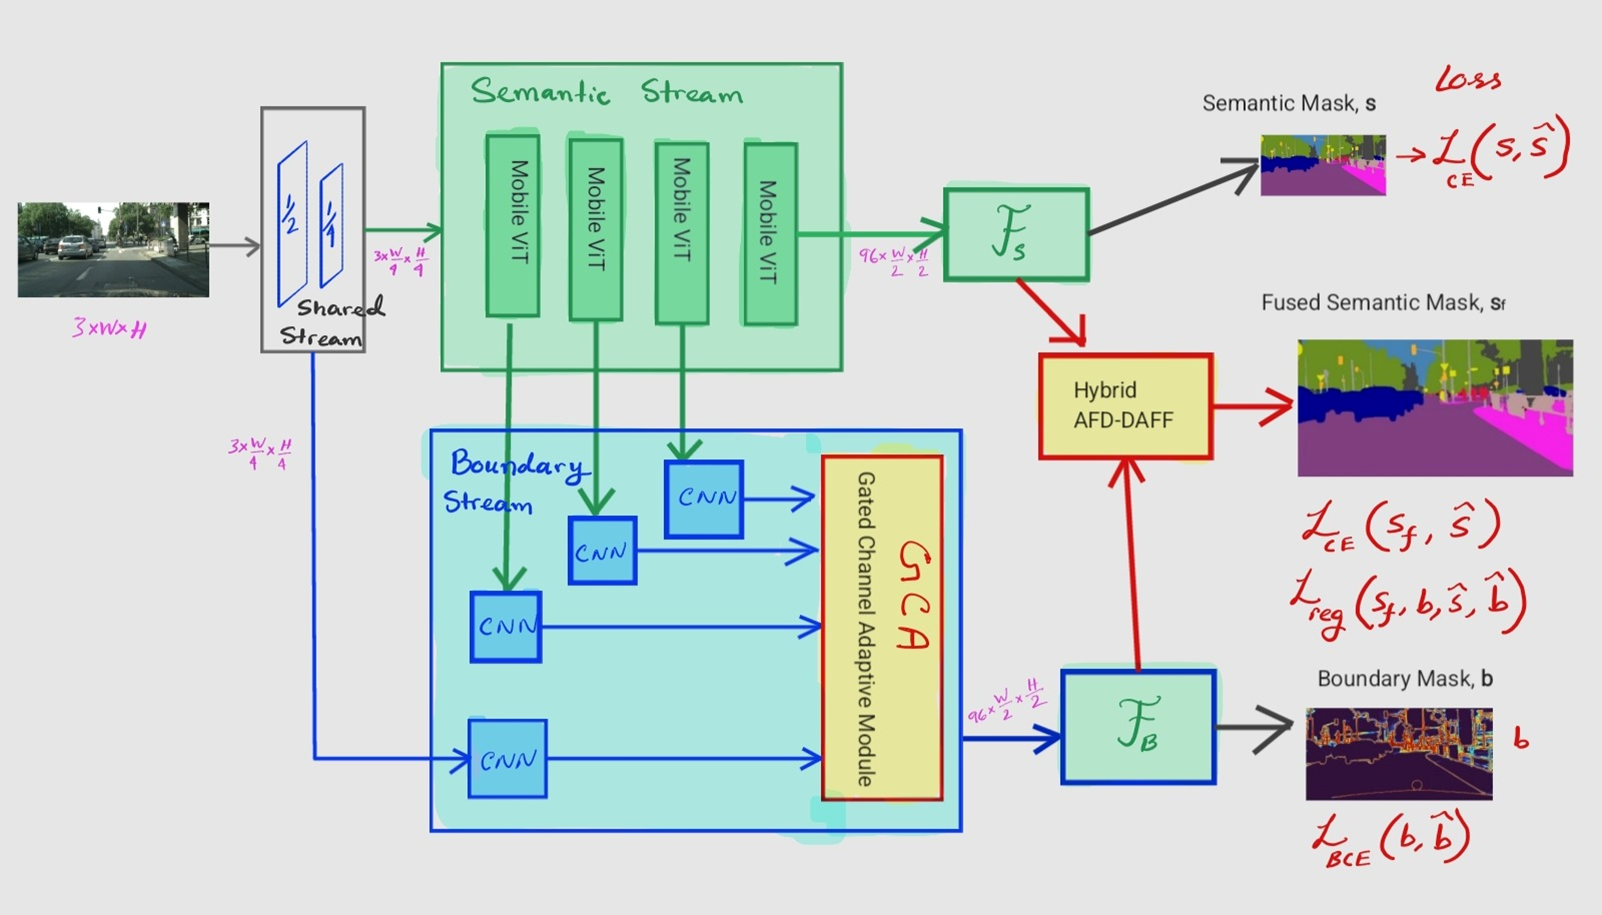

Our model follows a mixture of the Mobile Seed approach and the LSBNet Approach. The encoder portion is similar to the Mobile seed approach, excpet that we replace the Concatenation layer, with the Gated Channel Adaptive Module (GCA) adopted from the LSBNet. This was done because this layer performs better than basic concatenation; it not only concatenates but also learns importance of boundary features through the weights alpha, beta, and gamma; it basically uses attention based gated mechanism. This also allows it to adaptively learn feature per image. For example, in case of a car driving through freeway, vs. car driving through city, the boundary features would be given different levels of importance.

**Figure 6: Gated Channel Adaptive Module (GCA)**

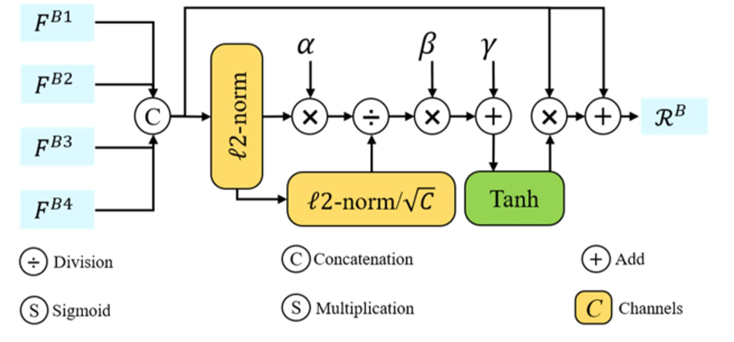

The modified encoder part of our module converts the 3x1024x2048 image into an embedding of shape 96x512x1024.

Two different embeddings are created, one for the Semantic Segmentaion, another for the Boundary Segmentation.

**Figure 7: Hybrid AFD-DAFF** Shape of data flowing through each section is also annotated in the figure

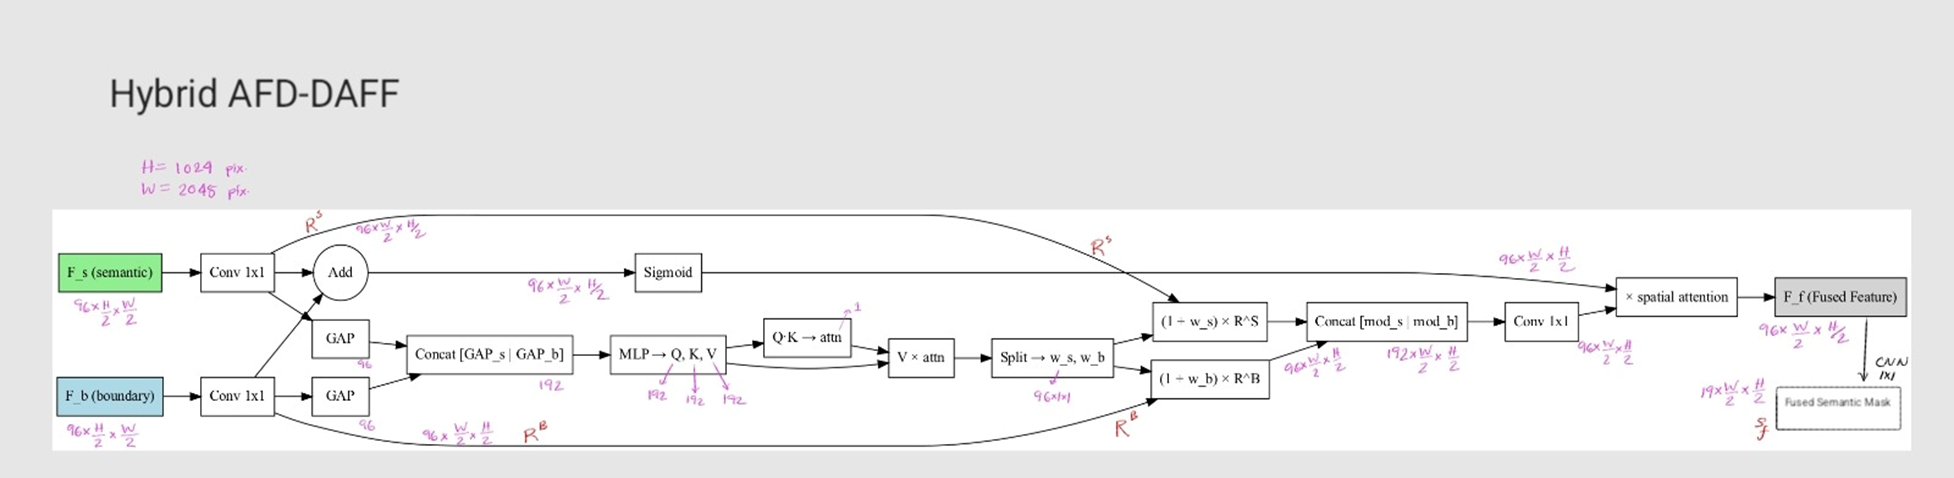

Next the two different embeddings Fs, and Fb are fused together to create the semantic map. This is done with our created hybrid AFD-DAFF decoder. This decoder uses attention mechanism as shown to learn which semantic class to give higher weightage to inside of a boundary. This helps in cases where boundary is narrow, for example street poles, and traffic lights.

# Code Detail for the Gated Channel Adaptive (GCA) module

In [ ]:
class GCA(nn.Module):
    """
    Gated Channel Attention as described in the architecture diagram.
    """

    def __init__(self, in_channels):
        super(GCA, self).__init__()
        self.alpha = nn.Parameter(torch.ones(1, in_channels, 1, 1))
        self.beta = nn.Parameter(torch.ones(1, in_channels, 1, 1))
        self.gamma = nn.Parameter(torch.zeros(1, in_channels, 1, 1))  # usually start from zero
        self.tanh = nn.Tanh()

    def forward(self, x):
        # x: (B, C, H, W)
        B, C, H, W = x.size()

        # 1. L2-norm along (H, W)
        l2_norm = torch.norm(x, p=2, dim=(2, 3), keepdim=True)  # Shape: (B, C, 1, 1)

        # 2. Divide by sqrt(C) (channel-wise norm scaling)
        norm_scale = math.sqrt(C)
        scaled_norm = l2_norm / norm_scale  # Shape: (B, C, 1, 1)

        # 3. α * scaled_norm * β + γ
        gated = self.alpha * scaled_norm * self.beta + self.gamma

        # 4. Tanh
        gated = self.tanh(gated)

        # 5. Add residual: R^B = F^B + F^B * Gated
        out = x + x * gated

        return out

# Code Detail for Hybrid AFD-DAFF Decoder

In [ ]:
class DAFF_AFDStyle(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(DAFF_AFDStyle, self).__init__()

        # print("Fuse channel: ", in_channels)

        # Projection for each stream
        self.conv_sem = nn.Conv2d(in_channels, in_channels, kernel_size=1)
        self.conv_bound = nn.Conv2d(in_channels, in_channels, kernel_size=1)

        # Spatial gate: sigmoid(Rs + Rb)
        self.spatial_gate = nn.Sigmoid()

        # Channel attention weights (AFD-style lightweight QKV)
        mid_channels = in_channels // reduction
        self.qkv_generator = nn.Sequential(
            nn.Linear(in_channels * 2, mid_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(mid_channels, (in_channels * 2) * 3, bias=False)  # Q, K, V
        )

        self.proj = nn.Linear(in_channels * 2, in_channels * 2)
        self.dropout = nn.Dropout(0.1)

        # Final fusion conv
        self.fusion_conv = nn.Conv2d(in_channels * 2, in_channels, kernel_size=1)

    def forward(self, sem_feat, bound_feat):
        B, C, H, W = sem_feat.shape
        ifPrint = False
        if ifPrint:  # Add a switch for printing only during training
            print(f"Input sem_feat shape: {sem_feat.shape}")
            print(f"Input bound_feat shape: {bound_feat.shape}")

        # Resize if needed
        if sem_feat.shape[2:] != bound_feat.shape[2:]:
            bound_feat = F.interpolate(bound_feat, size=sem_feat.shape[2:], mode='bilinear', align_corners=True)
            if ifPrint:
                print(f"Resized bound_feat shape: {bound_feat.shape}")

        # 1×1 conv projections
        r_s = self.conv_sem(sem_feat)
        r_b = self.conv_bound(bound_feat)
        if ifPrint:
            print(f"r_s shape: {r_s.shape}")
            print(f"r_b shape: {r_b.shape}")

        # Spatial gate from Rs + Rb
        spatial_attention = self.spatial_gate(r_s + r_b)
        if ifPrint:
            print(f"spatial_attention shape: {spatial_attention.shape}")

        # Global average pooled descriptors
        gap_r_s = torch.mean(r_s, dim=(2, 3))  # [B, C]
        gap_r_b = torch.mean(r_b, dim=(2, 3))  # [B, C]
        if ifPrint:
            print(f"gap_r_s shape: {gap_r_s.shape}")
            print(f"gap_r_b shape: {gap_r_b.shape}")

        context_vector = torch.cat([gap_r_s, gap_r_b], dim=1)  # [B, 2C]
        if ifPrint:
            print(f"context_vector shape: {context_vector.shape}")

        # Generate Q, K, V for attention
        qkv = self.qkv_generator(context_vector)  # [B, 6C]
        if ifPrint:
            print(f"qkv shape: {qkv.shape}")

        q, k, v = torch.chunk(qkv, 3, dim=1)      # each: [B, 2C]
        if ifPrint:
            print(f"q shape: {q.shape}, k shape: {k.shape}, v shape: {v.shape}")

        q = q.view(B, 1, -1)                      # [B, 1, 2C]
        k = k.view(B, -1, 1)                      # [B, 2C, 1]
        if ifPrint:
            print(f"q reshaped shape: {q.shape}, k reshaped shape: {k.shape}")

        attention = torch.bmm(q, k) / (C ** 0.5)  # [B, 1, 1]
        attention = torch.softmax(attention, dim=-1)  # still scalar but learned
        if ifPrint:
            print(f"attention shape: {attention.shape}")

        # Apply attention to V
        fusion_weights = (v.view(B, -1) * attention.view(B, 1))  # [B, 2C]
        if ifPrint:
            print(f"fusion_weights shape before projection: {fusion_weights.shape}")

        fusion_weights = self.dropout(self.proj(fusion_weights)).view(B, 2 * C, 1, 1)
        if ifPrint:
            print(f"fusion_weights shape after projection: {fusion_weights.shape}")

        w_s, w_b = torch.split(fusion_weights, C, dim=1)  # [B, C, 1, 1] each
        if ifPrint:
            print(f"w_s shape: {w_s.shape}, w_b shape: {w_b.shape}")

        # Residual-style modulation
        r_s_mod = r_s * (1 + w_s)
        r_b_mod = r_b * (1 + w_b)
        if ifPrint:
            print(f"r_s_mod shape: {r_s_mod.shape}, r_b_mod shape: {r_b_mod.shape}")

        # Final fusion: concat → conv → spatial mask
        fused = torch.cat([r_s_mod, r_b_mod], dim=1)       # [B, 2C, H, W]
        if ifPrint:
            print(f"fused shape after concat: {fused.shape}")

        fused = self.fusion_conv(fused)                    # [B, C, H, W]
        if ifPrint:
            print(f"fused shape after fusion_conv: {fused.shape}")

        fused = fused * spatial_attention                  # apply spatial gate
        if ifPrint:
            print(f"fused shape after spatial_attention: {fused.shape}\n")

        return fused

# Implementation

### Project Folder Structure

```
Mobile-Seed-MIE1517/
├── configs/                 # Model configuration files
│   └── Mobile_Seed/
│       └── MS_tiny_cityscapes.py
├── ckpt/                    # Pretrained model checkpoints
│   └── GCA.pth              # Checkpoint for inference
├── demo/                    # Demo scripts and output media
│   ├── image_demo.py        # Run inference on a single image
│   ├── video_demo.py        # Run inference on a video file
│   └── demo.png             # Sample input image
├── tools/                   # MMSegmentation test/train tools
├── data/                    # Sample data directory
│   └── dash_cam/
│       └── Stockyards_cropped.ts
└── README.md
```

---

### Image Demo

Run segmentation on a single image and save the output mask.

#### Usage

```bash
python demo/image_demo.py ${IMAGE_FILE} ${CONFIG_FILE} ${CHECKPOINT_FILE} ${OUTPUT_SEG} \
--device ${DEVICE_NAME} --palette ${PALETTE}
```

#### Example

```bash
python demo/image_demo.py demo/demo.png configs/Mobile_Seed/MS_tiny_cityscapes.py \
ckpt/GCA.pth demo/out_seg.png --device cuda:0 --palette cityscapes
```

---

### Video Demo

Run segmentation on a full dash cam `.ts` video and save the overlaid output.

#### Usage

```bash
python demo/video_demo.py ${VIDEO_FILE} ${CONFIG_FILE} ${CHECKPOINT_FILE} ${OUTPUT_VIDEO} \
--device ${DEVICE_NAME} --palette ${PALETTE} --prefix ${PREFIX}
```

#### Example

```bash
python demo/video_demo.py data/dash_cam/Stockyards_cropped.ts \
configs/Mobile_Seed/MS_tiny_cityscapes.py \
ckpt/GCA.pth \
demo/Stockyards_cropped_gca.mp4 \
--device cuda:0 --palette cityscapes --prefix gca
```


# Training Instructions

To train the Mobile-Seed model from scratch or fine-tune it on a specific dataset (e.g., Cityscapes), follow these steps:

### 1. Prepare the Dataset

Download the [Cityscapes](https://www.cityscapes-dataset.com/downloads/) dataset and structure it as follows:

```
data/cityscapes/
├── leftImg8bit/
│   ├── train/
│   ├── val/
│   └── test/
└── gtFine/
    ├── train/
    ├── val/
    └── test/
```

Update the dataset root path in your config file if needed:
```python
# configs/Mobile_Seed/MS_tiny_cityscapes.py
dataset_type = 'CityscapesDataset'
data_root = 'data/cityscapes/'
```

---

### 2. Configure Training Parameters

Modify hyperparameters such as:
```
| Parameter             | Description |
|----------------------|-------------|
| `max_iters`          | The total number of training iterations. Increase for longer training or reduce for debugging. |
| `lr_config`          | Learning rate scheduling. If you reduce batch size (e.g., from 8 to 3), scale the LR accordingly (e.g., multiply by 3/8). |
| `checkpoint_config`  | Controls how often checkpoints are saved. Example: `interval=1000` means save every 1000 iterations. |
| `runner`             | Defines how training is scheduled (e.g., `IterBasedRunner` or `EpochBasedRunner`). Iter-based is often used for segmentation. |
| `log_config`         | Sets how often logs are printed. Adjust `interval` to control frequency. Useful for monitoring training progress. |
| `samples_per_gpu`    | Number of images loaded per GPU per iteration. Reduce if you encounter OOM (e.g., changed from 8 ➝ 3 due to limited VRAM). |
| `workers_per_gpu`    | Number of data loader workers per GPU. Increase to speed up data loading, but too high may cause instability on some systems. |

```
Example config file:
```
configs/Mobile_Seed/MS_tiny_cityscapes.py
```
#### 2.1 Configuration Breakdown
The training configuration is modular and leverages `_base_` files to keep things clean and manageable:

```python
_base_ = [
    '../_base_/models/Mobile_Seed.py',
    '../_base_/datasets/cityscapes_1024x1024_boundary.py',
    '../_base_/default_runtime.py',
    '../_base_/schedules/schedule_160k.py'
]
```

Each `_base_` file sets defaults for a specific part of the pipeline:

| File                                | Purpose                                     |
|-------------------------------------|---------------------------------------------|
| `Mobile_Seed.py`                    | Defines the backbone and decoding heads     |
| `cityscapes_1024x1024_boundary.py`  | Dataset and preprocessing config            |
| `default_runtime.py`                | Logging, checkpoint, and evaluation configs |
| `schedule_160k.py`                  | Training loop schedule (160k iterations)    |

---

### Model Configuration

```python
model = dict(
    pretrained='./ckpt/AFFormer_tiny_ImageNet1k.pth',
    backbone=dict(type='AFFormer_for_MS_tiny'),
    decode_head=[...]
)
```

- **`pretrained`**: Uses ImageNet-pretrained weights for the AFFormer backbone.
- **`decode_head`**: Includes two heads:
  - `BoundaryHead`: Detects edges using multiple resolution inputs.
  - `RefineHead`: Refines predictions using fused high-level features.

---

### Optimizer & Learning Rate

```python
optimizer = dict(
    _delete_=True,
    type='AdamW',
    lr=0.0004 * 3 / 8,
    betas=(0.9, 0.999),
    weight_decay=0.01
)
```

- **AdamW**: Chosen for better generalization and support for vision transformer-style architectures.
- **Learning Rate Scaling**: Scaled down by `3/8` due to batch size reduction (from 8 to 3).

```python
lr_config = dict(
    _delete_=True,
    policy='poly',
    warmup='linear',
    warmup_iters=1500,
    warmup_ratio=1e-6,
    power=1.0,
    min_lr=0.0,
    by_epoch=False
)
```

- **Poly Policy**: Standard for semantic segmentation, gradually reduces the LR.
- **Warmup**: Stabilizes training at the beginning.

---

### Data Loader

```python
data = dict(
    samples_per_gpu=3,
    workers_per_gpu=8
)
```

- **`samples_per_gpu=3`**: Reduced from 8 due to limited VRAM.
- **`workers_per_gpu=8`**: Increases data loading speed

---

### Other Notes

```python
find_unused_parameters=True
```

- Set to `True` because some parameters may not be used during backprop (e.g., due to multiple heads or modular structures like AFFormer).
---

### 3. Train the Model

Activate your conda environment and run for a single GPU:

```bash
tools/train_single_gpu.sh
```

---

### 4. Evaluate the Model

To test the trained model:

```bash
tools/evaluate_single_gpu.sh
```

---

### 5. Visualize Results

Use the demo scripts (`image_demo.py` or `video_demo.py`) with your trained checkpoint to visualize segmentation results.

---

> Note: Ensure the environment includes the necessary MMCV and MMSEG versions compatible with your config.


# Demonstration

This clip demonstrates our model’s performance on dashcam footage recorded in downtown Toronto, shown at 2X playback speed.

In [ ]:
from IPython.display import Video

# Assuming Media1.mp4 is in the current directory (usually /content/)
Video("/content/Media1.mp4", embed=True, width=640, height=480)


# Results

We evaluated our model against MobileSeed using multiple semantic segmentation performance metrics including mean Intersection over Union (mIoU), mean class accuracy (mAcc), and average accuracy (aAcc).

### What is mIoU

Mean Intersection over Union is the ratio of true predicted pixels (intersection), to the area of union of entire predicted region and ground truth. This can be visualized from the image provided.

**Figure 8:** Result evaluation metrics used in our model

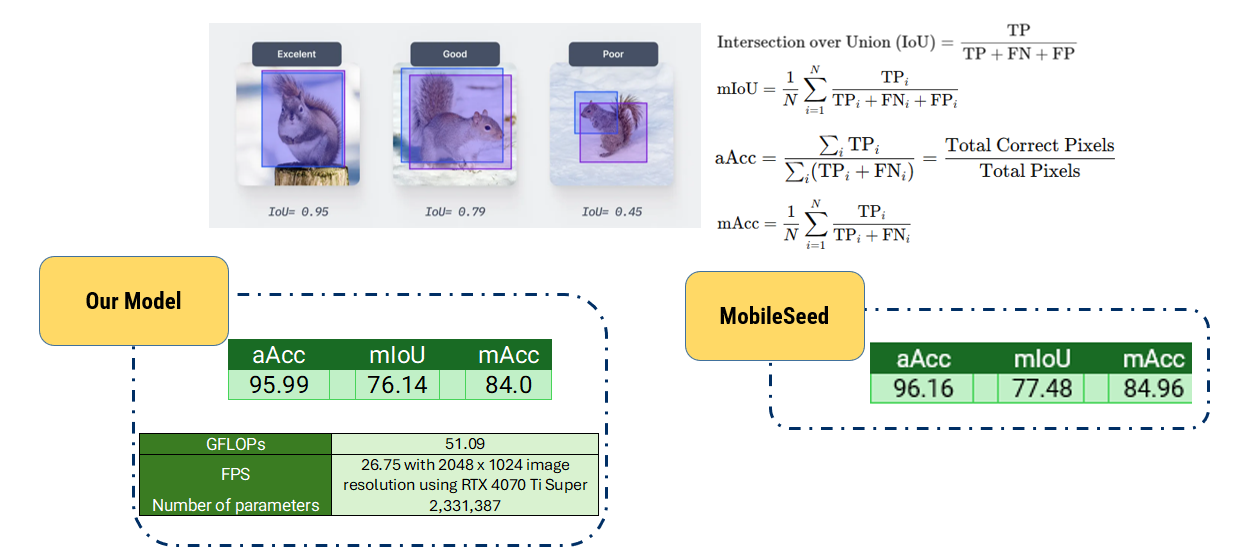

Our model achieved a competitive aAcc of 95.99%, mIoU of 76.14%, and mAcc of 84.0%. our model achieves this performance with reasonable computational cost of 51.09 GFLOPs, running at 26.75 FPS on high-resolution images using an RTX 4070 Ti Super GPU.

**Figure 9:** Results for Categorial performance of our model

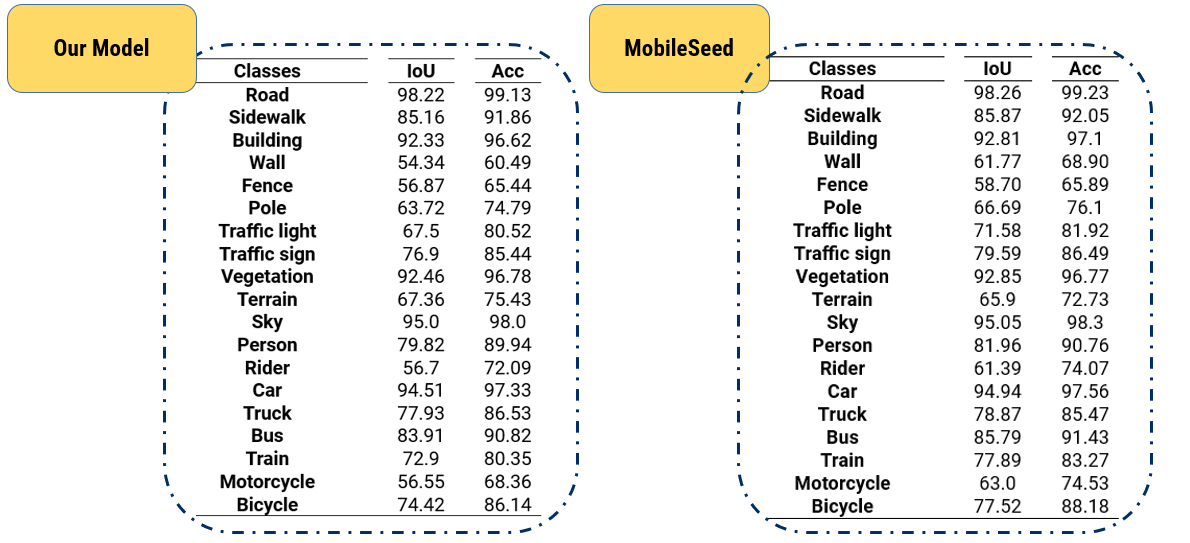

In terms of categorical perfomance, for classifying each distinct class, our model performed similar to the Mobile Seed Model.

## Visual Representation of Results



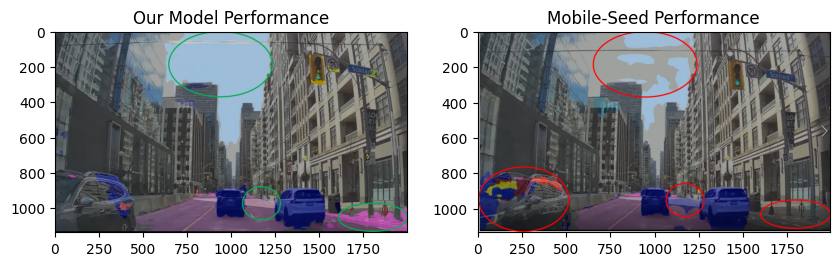

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

img1_path = '/content/img1.png'
img2_path = '/content/img2.png'

# Check if the files exist
if os.path.exists(img1_path) and os.path.exists(img2_path):
  img1 = mpimg.imread(img1_path)
  img2 = mpimg.imread(img2_path)

  # Display the images
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(img1)
  plt.title('Our Model Performance')

  plt.subplot(1, 2, 2)
  plt.imshow(img2)
  plt.title('Mobile-Seed Performance')

  plt.show()
else:
  print("One or both image files not found.")


As shown, Our model more accurately captures the sidewalk and sky regions, and it's also better at distinguishing the distance between vehicles. Notably, MobileSeed misclassifies parts of the road as cars, whereas our model correctly labels those areas.

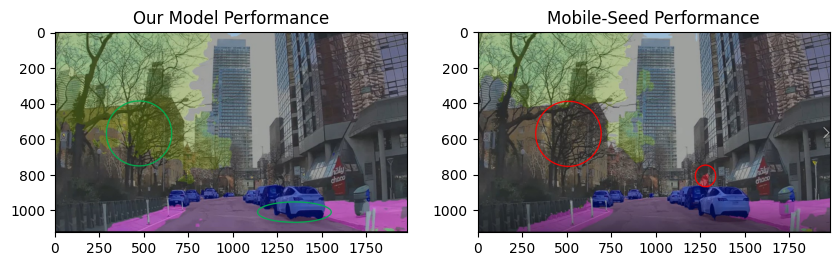

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os

img1_path = '/content/img3.png'
img2_path = '/content/img4.png'

# Check if the files exist
if os.path.exists(img1_path) and os.path.exists(img2_path):
  img1 = mpimg.imread(img1_path)
  img2 = mpimg.imread(img2_path)

  # Display the images
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.imshow(img1)
  plt.title('Our Model Performance')

  plt.subplot(1, 2, 2)
  plt.imshow(img2)
  plt.title('Mobile-Seed Performance')

  plt.show()
else:
  print("One or both image files not found.")

This comparison highlights our model’s improved ability to identify trees and accurately detect car boundaries. You can see that MobileSeed struggles with distinguishing the fine tree structures and misclassifies parts of the cars, while our model handles both more precisely.

# Discussion and Future Improvements

## Challenges

Throughout the development process, we encountered several challenges that impacted our workflow and experimentation pace. Software dependency issues, particularly with newer research models, led to significant delays due to compatibility conflicts. Replicating the results of the seed project required extensive retraining, making fair benchmarking time-consuming and resource-intensive. Additionally, validating architectural modifications demanded a deep understanding of the existing model, complicating the assessment of individual changes. Fine-tuning the model on new data was further hindered by a manual pre-labeling bottleneck, with each image requiring up to 40 minutes of labor depending on object density.


## Takeaway

From our experience, two key strategies significantly improved our workflow. First, analyzing model architecture early in the research process helped us avoid spending time on fundamentally incompatible models. For instance, LBSNet was a strong candidate due to its architectural similarity to MobileSeed. Second, when full integration was challenging, we validated modifications independently using mock data. This approach allowed us to test changes in isolation and ensure stability before incorporating them into the complete pipeline.

## Future Improvements

The dashcam frames used in our test phase have spatial misalignments between the captured images and real-world object geometries due to fisheye distortion. This mismatch has a negative effect to model performance, especially in tasks requiring precise spatial reasoning like semantic segmentation. Due to time constraints, we did not apply geometric correction techniques in this project. In our future work, we will prioritize implementing distortion correction to improve data quality and alignment.

As discussed in the challenge section, our training batch size was constrained by limited hardware resources. A small batch size may affect model convergence and generalization. Future research of this project will benefit from access to more powerful GPUs(RTX 5090) or distributed training environments, allowing for larger batch sizes and more efficient hyperparameter tuning.

Our current model emphasizes boundary detection, which improved edge clarity but came at the cost of overall segmentation strength. To achieve better overall performance, future work should focus on exploring hybrid architectures or loss functions that can effectively balance boundary refinement with robust segmentation capabilities.

# References

[1] Y. Liao et al., "Mobile-Seed: Joint Semantic Segmentation and Boundary Detection for Mobile Robots," IEEE Robotics and Automation Letters, 2024.

[2] L. Tong, K. Qian, and X. Jing, "LBSNet: Lightweight Joint Boundary Detection and Semantic Segmentation for Transparent and Reflective Objects," IEEE Robotics and Automation Letters, vol. 10, no. 2, pp. 955-962, Feb. 2025, doi: 10.1109/LRA.2024.3518302.